<a href="https://colab.research.google.com/github/malienist/FIRST-JP/blob/main/notebooks/fashion_mnist_PGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attack on Fashion-MNIST using CleverHans

Welcome to this Colab notebook where we will demonstrate how to perform an adversarial attack on the Fashion-MNIST dataset using the CleverHans library. This notebook will guide you through the process of training a simple Convolutional Neural Network (CNN) model, saving it, and then generating adversarial examples using the Projected Gradient Descent (PGD) method.

## Objectives
1. **Train a Simple CNN Model**: We will start by defining and training a simple CNN on the Fashion-MNIST dataset to classify different types of clothing items.
2. **Save the Trained Model**: After training the model, we will save its state for later use.
3. **Generate Adversarial Examples**: Using the CleverHans library, we will apply the PGD attack to generate adversarial examples that can fool the trained model.
4. **Visualize Results**: We will visualize the original images, adversarial images, and the perturbations applied to understand the impact of the attack.

## Fashion-MNIST Dataset
The Fashion-MNIST dataset consists of 70,000 grayscale images in 10 categories, with 7,000 images per category. The images show individual articles of clothing at low resolution (28x28 pixels).

The 10 classes in the dataset are:
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

## Setup
Before we begin, ensure you have the necessary libraries installed. You can install them using pip:

```sh
pip install cleverhans torch torchvision matplotlib


In [1]:
!pip install torch torchvision matplotlib numpy foolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

## Steps
1. **Define and Train the CNN Model**: We will build a simple CNN architecture and train it on the Fashion-MNIST dataset.
2. **Save the Model**: Once trained, we will save the model to use it for generating adversarial examples.
3. **Apply PGD Attack**: Using CleverHans, we will apply the PGD attack to create adversarial images.
4. **Visualize the Results**: We will compare the original images with the adversarial images and display the perturbations applied.

Let's get started!

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import foolbox as fb

# Define the transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load Fashion-MNIST dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# Define a simple CNN model
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN()

# Training parameters
epochs = 1
learning_rate = 0.001

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch {epoch+1}, Batch {i}, Loss: {loss.item()}')

# Save the model
torch.save(model.state_dict(), 'simple_cnn.pth')
print("Model saved as simple_cnn.pth")

# Load Fashion-MNIST dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)


# Load the model (for attack)
model.load_state_dict(torch.load('simple_cnn.pth'))
model.eval()

# Wrap the model with Foolbox
fmodel = fb.PyTorchModel(model, bounds=(-1, 1))

# Fetch a sample from the dataset
images, labels = next(iter(testloader))
images, labels = images.to(torch.device('cpu')), labels.to(torch.device('cpu'))

# Run pre-attack predictions
logits = model(images)
pre_attack_predictions = torch.argmax(logits, axis=1)


100%|██████████| 26421880/26421880 [00:01<00:00, 14532760.59it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 233487.14it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4271635.04it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17329275.27it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Epoch 1, Batch 0, Loss: 2.300626039505005
Epoch 1, Batch 100, Loss: 0.520338773727417
Epoch 1, Batch 200, Loss: 0.26914432644844055
Epoch 1, Batch 300, Loss: 0.3697139024734497
Epoch 1, Batch 400, Loss: 0.25357115268707275
Epoch 1, Batch 500, Loss: 0.312887042760849
Epoch 1, Batch 600, Loss: 0.21266940236091614
Epoch 1, Batch 700, Loss: 0.19467653334140778
Epoch 1, Batch 800, Loss: 0.29183295369148254
Epoch 1, Batch 900, Loss: 0.20545627176761627
Model saved as simple_cnn.pth


In [6]:
# Apply PGD attack
epsilon = 0.3  # Maximum perturbation
steps = 40  # Number of attack iterations
step_size = 0.01  # Step size
attack = fb.attacks.LinfPGD(steps=steps, rel_stepsize=step_size/epsilon)
raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilon)

# Run post-attack predictions
logits_adv = model(clipped_advs)
post_attack_predictions = torch.argmax(logits_adv, axis=1)

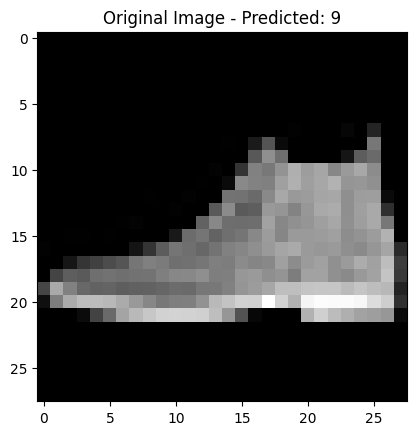

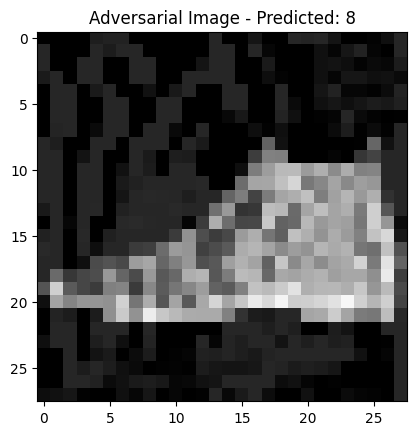

In [7]:
# Visualize pre-attack and post-attack images
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.show()

# Show original image
imshow(torchvision.utils.make_grid(images), title=f'Original Image - Predicted: {pre_attack_predictions.item()}')

# Show adversarial image
imshow(torchvision.utils.make_grid(clipped_advs), title=f'Adversarial Image - Predicted: {post_attack_predictions.item()}')

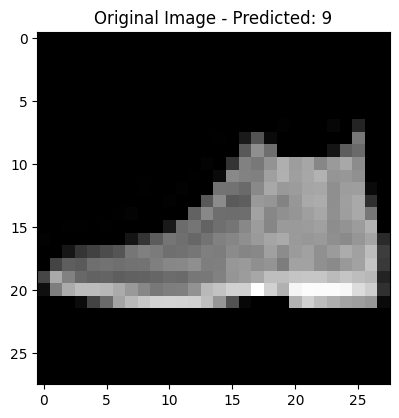

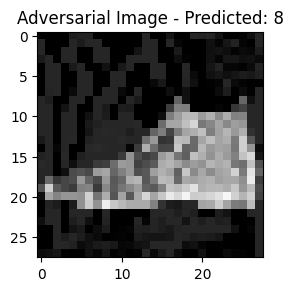

In [8]:
# Show original and adversarial images side by side
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
imshow(torchvision.utils.make_grid(images), title=f'Original Image - Predicted: {pre_attack_predictions.item()}')

# Adversarial Image
plt.subplot(1, 2, 2)
imshow(torchvision.utils.make_grid(clipped_advs), title=f'Adversarial Image - Predicted: {post_attack_predictions.item()}')

plt.show()

Epoch 1, Batch 0, Loss: 2.296656608581543
Epoch 1, Batch 100, Loss: 0.39042314887046814
Epoch 1, Batch 200, Loss: 0.3779434859752655
Epoch 1, Batch 300, Loss: 0.3852786719799042
Epoch 1, Batch 400, Loss: 0.5000240802764893
Epoch 1, Batch 500, Loss: 0.35985273122787476
Epoch 1, Batch 600, Loss: 0.15526056289672852
Epoch 1, Batch 700, Loss: 0.24967624247074127
Epoch 1, Batch 800, Loss: 0.20256316661834717
Epoch 1, Batch 900, Loss: 0.19634827971458435
Epoch 2, Batch 0, Loss: 0.2144239991903305
Epoch 2, Batch 100, Loss: 0.12197723239660263
Epoch 2, Batch 200, Loss: 0.28020578622817993
Epoch 2, Batch 300, Loss: 0.2618730366230011
Epoch 2, Batch 400, Loss: 0.25029677152633667
Epoch 2, Batch 500, Loss: 0.2780311703681946
Epoch 2, Batch 600, Loss: 0.26904064416885376
Epoch 2, Batch 700, Loss: 0.319731205701828
Epoch 2, Batch 800, Loss: 0.23625090718269348
Epoch 2, Batch 900, Loss: 0.24241939187049866
Epoch 3, Batch 0, Loss: 0.12735594809055328
Epoch 3, Batch 100, Loss: 0.19723215699195862
Epoc

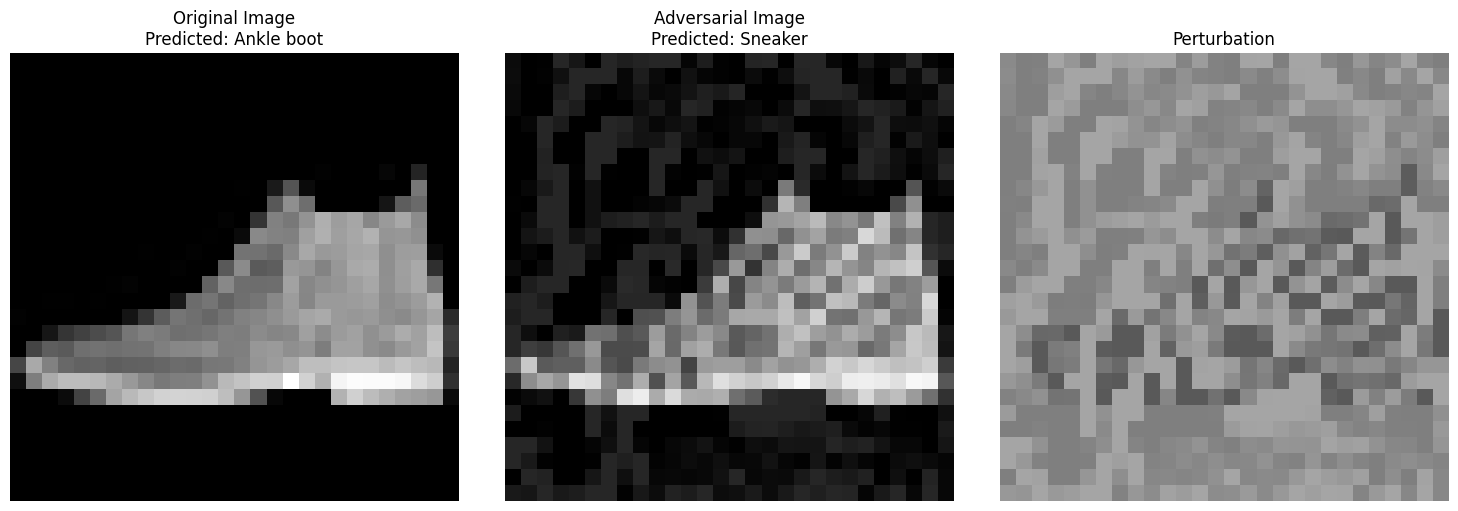

In [9]:
# Define class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Define a simple CNN model
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load Fashion-MNIST dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

# Instantiate the model
model = SimpleCNN()

# Training parameters
epochs = 5
learning_rate = 0.001

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch {epoch+1}, Batch {i}, Loss: {loss.item()}')

# Save the model
torch.save(model.state_dict(), 'simple_cnn.pth')
print("Model saved as simple_cnn.pth")

# Load the model (for attack)
model.load_state_dict(torch.load('simple_cnn.pth'))
model.eval()

# Wrap the model with Foolbox
fmodel = fb.PyTorchModel(model, bounds=(-1, 1))

# Fetch a sample from the dataset
images, labels = next(iter(testloader))
images, labels = images.to(torch.device('cpu')), labels.to(torch.device('cpu'))

# Run pre-attack predictions
logits = model(images)
pre_attack_predictions = torch.argmax(logits, axis=1)

# Apply PGD attack
epsilon = 0.3  # Maximum perturbation
steps = 40  # Number of attack iterations
step_size = 0.01  # Step size
attack = fb.attacks.LinfPGD(steps=steps, rel_stepsize=step_size/epsilon)
raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilon)

# Run post-attack predictions
logits_adv = model(clipped_advs)
post_attack_predictions = torch.argmax(logits_adv, axis=1)

# Visualize pre-attack and post-attack images, and the perturbation
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.axis('off')

# Calculate perturbation
perturbation = clipped_advs - images

# Show original, adversarial, and perturbation images side by side
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
imshow(torchvision.utils.make_grid(images),
       title=f'Original Image\nPredicted: {class_names[pre_attack_predictions.item()]}')

# Adversarial Image
plt.subplot(1, 3, 2)
imshow(torchvision.utils.make_grid(clipped_advs),
       title=f'Adversarial Image\nPredicted: {class_names[post_attack_predictions.item()]}')

# Perturbation
plt.subplot(1, 3, 3)
imshow(torchvision.utils.make_grid(perturbation),
       title='Perturbation')

plt.tight_layout()
plt.show()